In [41]:
from pathlib import Path
from fastai import *
from fastai.vision.all import *
import os
import pandas as pd

In [42]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '7'
data_path = Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset')

In [19]:
dls = ImageDataLoaders.from_folder(data_path,bs=32,item_tfms=Resize(64),batch_tfms=Normalize.from_stats(*imagenet_stats))
dls.train_ds.items[:3]

[Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset/train/2/1740.png'),
 Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset/train/2/1989.png'),
 Path('/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/dataset/train/2/1597.png')]

In [ ]:
dls.show_batch()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0006918309954926372)

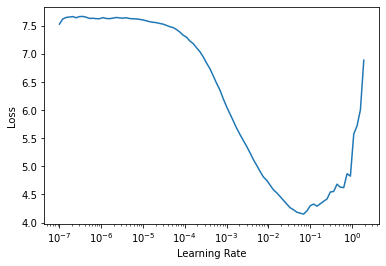

In [20]:
#learn = cnn_learner(dls, xresnext50, metrics=[accuracy, error_rate], model_dir='./fastai_model')
#learn.lr_find()
model = xse_resnext50(pretrained=True)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find()

In [21]:
learn.fit_one_cycle(5, 0.005, cbs=SaveModelCallback())
learn.export('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xse_resnext50-50-5-epoch.pkl')
#learn.save('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/stage-1-rn50')

epoch,train_loss,valid_loss,accuracy,time
0,0.763641,0.904629,0.695604,02:07
1,0.481747,0.379888,0.854725,02:01
2,0.346490,0.302339,0.889451,02:06
3,0.255123,0.189448,0.932308,02:13
4,0.201704,0.162756,0.940000,02:08


Better model found at epoch 0 with valid_loss value: 0.9046289324760437.
Better model found at epoch 1 with valid_loss value: 0.3798878788948059.
Better model found at epoch 2 with valid_loss value: 0.3023391664028168.
Better model found at epoch 3 with valid_loss value: 0.189447820186615.
Better model found at epoch 4 with valid_loss value: 0.1627563089132309.


In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
interp.plot_top_losses(5, nrows=1)

## incremental training

In [26]:
learn_inf = load_learner('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xse_resnext50-50-5-epoch.pkl')
dls = ImageDataLoaders.from_folder(data_path,bs=32, item_tfms=[Resize(224)],batch_tfms=Normalize.from_stats(*imagenet_stats))
learn_inf.dls = dls

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=9.12010818865383e-07)

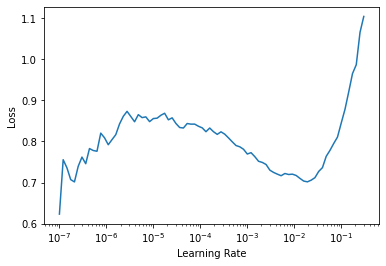

In [27]:
learn_inf.lr_find()

In [40]:
learn_inf.fit_one_cycle(5, 0.001, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,accuracy,time
0,nan,None,None,00:01


/home/jns2szh/.conda/envs/fast/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [33]:
learn.export('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xse_resnext50-50-5-epoch.pkl')


## inference

In [38]:
learn_inf = load_learner('/home/jns2szh/code/pytorch-ImageNet-CIFAR-COCO-VOC-training-master/imagenet_experiments/regnet_imagenet_Dataparallel_train_example/xse_resnext50-50-5-epoch.pkl',cpu=False)
test_csv = '/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/inference.csv'
test_list = pd.read_csv(test_csv)
path_list = []

for i in range(len(test_list['img_path'])):
    img_path = '/home/jns2szh/code/Basic_CNNs_TensorFlow2-master/'+test_list['img_path'][i]
    path_list.append(Path(img_path))

probs,targs = learn_inf.get_preds(dl=learn_inf.dls.test_dl(path_list))

In [39]:
dry = []
wet = []
snowy = []
na = []

result = probs.cuda().data.cpu().numpy()
for i in range(len(result)):
    #print(result)
    dry.append(result[i][0])
    wet.append(result[i][1])
    snowy.append(result[i][2])
    na.append(result[i][3])

cont_list = {'dry':dry, 'wet':wet, 'snowy':snowy, 'na':na}
df = pd.DataFrame(cont_list, columns=['dry','wet','snowy','na'])
df.to_csv('result.csv')